In [1]:
import os
os.getcwd()

'/home/agustin/plant-traits/notebooks'

In [2]:
cd ..

/home/agustin/plant-traits


/home/agustin/.cache/pypoetry/virtualenvs/plant-traits-y5eu6WKG-py3.10/lib/python3.10/site-packages/IPython/core/magics/osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [3]:
import pandas as pd
import numpy as np
import scipy.spatial.distance as distance
from scipy.stats import zscore

from sklearn.preprocessing import StandardScaler
from src.preprocess_utils import drop_outliers, scale_variables
from src.constants import TARGETS, SD, ID, SPECIES
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import warnings

def magnitude(x):
    return np.sign(x)* 10**int(np.log10(np.abs(x)))

In [4]:
def display_plants(df, species_id, max_images=10):

    df = df[df['species']==species_id]
    

    display_data = df.head(max_images)
    print(f"Species ID: {int(df.iloc[0].species)}")
    
    for trait in TARGETS:
        print(f"{trait}: {round(display_data.iloc[0][trait], 4)}  ", end="")

    ncols = 5
    nrows = int(np.ceil(len(display_data) / ncols))

    fig, axs = plt.subplots(nrows, ncols, figsize=(15, 3 * nrows))
    axs = axs.flatten()

    for idx, (i, row) in enumerate(df.iterrows()):
        if idx >= len(axs):  # Check to avoid IndexError
            break
        image_id = i
        image_path = os.path.join('data/planttraits2024/train_images', f"{image_id}.jpeg")
        img = mpimg.imread(image_path)
        _ = axs[idx].imshow(img)
        _ = axs[idx].axis('off')  # Hide axes

    # Hide unused subplots
    for ax in axs[len(display_data):]:
        _ = ax.axis('off')

        warnings.filterwarnings('ignore', category=UserWarning)
        _ = plt.tight_layout()
        _ = plt.show()
        
        
        
        print ("\n")



In [5]:
train_df = pd.read_csv('data/planttraits2024/train.csv')
test_df = pd.read_csv('data/planttraits2024/test.csv')

pd.Series(train_df.columns.sort_values()).to_csv('data/columns.csv')
variables = train_df.columns[~train_df.columns.isin(TARGETS+SD+[ID])]
meta_variables = variables.str.split('_').str[:2].str.join("_").unique()

In [6]:
train_df.index = train_df[ID]
# train_df = train_df.drop(axis=1, labels=[ID])

train_df.head()

,id,WORLDCLIM_BIO1_annual_mean_temperature,WORLDCLIM_BIO12_annual_precipitation,WORLDCLIM_BIO13.BIO14_delta_precipitation_of_wettest_and_dryest_month,WORLDCLIM_BIO15_precipitation_seasonality,WORLDCLIM_BIO4_temperature_seasonality,WORLDCLIM_BIO7_temperature_annual_range,SOIL_bdod_0.5cm_mean_0.01_deg,SOIL_bdod_100.200cm_mean_0.01_deg,SOIL_bdod_15.30cm_mean_0.01_deg,...,X18_mean,X26_mean,X50_mean,X3112_mean,X4_sd,X11_sd,X18_sd,X26_sd,X50_sd,X3112_sd
id,,,,,,,,,,,,,,,,,,,,,
192027691,192027691,12.235703,374.466675,62.524445,72.256844,773.592041,33.277779,125,149,136,...,0.117484,1.243779,1.849375,50.216034,0.008921,1.601473,0.025441,0.153608,0.279610,15.045054
195542235,195542235,17.270555,90.239998,10.351111,38.220940,859.193298,40.009777,124,144,138,...,0.389315,0.642940,1.353468,574.098472,0.003102,0.258078,0.000866,0.034630,0.010165,11.004477
196639184,196639184,14.254504,902.071411,49.642857,17.873655,387.977753,22.807142,107,133,119,...,8.552908,0.395241,2.343153,1130.096731,NaN,NaN,NaN,NaN,NaN,NaN
195728812,195728812,18.680834,1473.933350,163.100006,45.009758,381.053986,20.436666,120,131,125,...,1.083629,0.154200,1.155308,1042.686546,0.011692,2.818356,0.110673,0.011334,0.229224,141.857187
195251545,195251545,0.673204,530.088867,50.857777,38.230709,1323.526855,45.891998,91,146,120,...,0.657585,10.919966,2.246226,2386.467180,0.006157,1.128000,0.026996,0.553815,0.107092,87.146899


In [7]:
species_serie = pd.factorize(pd._libs.lib.fast_zip([train_df[x].values for x in TARGETS]))[0]
train_df['species'] = species_serie
train_df['species'].nunique()

19799

In [8]:
species_df = train_df[['species']+TARGETS+SD]

counts = species_df.groupby(by='species').count().iloc[:,0]
counts.name = 'counts'

species_df.index = train_df['species']
species_df = species_df.drop_duplicates()
species_df = species_df.drop(axis=1, labels=['species'])

species_df = species_df.merge(counts, left_index=True, right_index=True)

In [9]:
train_df

,id,WORLDCLIM_BIO1_annual_mean_temperature,WORLDCLIM_BIO12_annual_precipitation,WORLDCLIM_BIO13.BIO14_delta_precipitation_of_wettest_and_dryest_month,WORLDCLIM_BIO15_precipitation_seasonality,WORLDCLIM_BIO4_temperature_seasonality,WORLDCLIM_BIO7_temperature_annual_range,SOIL_bdod_0.5cm_mean_0.01_deg,SOIL_bdod_100.200cm_mean_0.01_deg,SOIL_bdod_15.30cm_mean_0.01_deg,...,X26_mean,X50_mean,X3112_mean,X4_sd,X11_sd,X18_sd,X26_sd,X50_sd,X3112_sd,species
id,,,,,,,,,,,,,,,,,,,,,
192027691,192027691,12.235703,374.466675,62.524445,72.256844,773.592041,33.277779,125,149,136,...,1.243779,1.849375,50.216034,0.008921,1.601473,0.025441,0.153608,0.279610,15.045054,0
195542235,195542235,17.270555,90.239998,10.351111,38.220940,859.193298,40.009777,124,144,138,...,0.642940,1.353468,574.098472,0.003102,0.258078,0.000866,0.034630,0.010165,11.004477,1
196639184,196639184,14.254504,902.071411,49.642857,17.873655,387.977753,22.807142,107,133,119,...,0.395241,2.343153,1130.096731,NaN,NaN,NaN,NaN,NaN,NaN,2
195728812,195728812,18.680834,1473.933350,163.100006,45.009758,381.053986,20.436666,120,131,125,...,0.154200,1.155308,1042.686546,0.011692,2.818356,0.110673,0.011334,0.229224,141.857187,3
195251545,195251545,0.673204,530.088867,50.857777,38.230709,1323.526855,45.891998,91,146,120,...,10.919966,2.246226,2386.467180,0.006157,1.128000,0.026996,0.553815,0.107092,87.146899,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
190558785,190558785,19.472172,244.795914,39.127552,67.074493,472.710358,27.758673,118,140,131,...,1.783193,1.608341,969.547831,NaN,NaN,NaN,NaN,NaN,NaN,10870
194523231,194523231,13.724150,1450.000000,162.260208,43.139324,652.716858,26.694387,125,144,135,...,12.713048,2.418300,1630.015480,0.005474,0.128133,0.117010,3.164520,0.082212,136.503697,6770
195888987,195888987,14.741204,581.866638,109.231110,89.272148,507.273010,26.874668,118,155,136,...,10.206478,2.722599,602.229880,0.019727,0.215040,0.156309,0.919139,0.079395,26.159626,3203


In [10]:
magnitude_counts = train_df[TARGETS].map(magnitude, na_action='ignore').apply(pd.value_counts)
magnitude_counts


/tmp/ipykernel_66741/3309805985.py:1: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  magnitude_counts = train_df[TARGETS].map(magnitude, na_action='ignore').apply(pd.value_counts)


,X4_mean,X11_mean,X18_mean,X26_mean,X50_mean,X3112_mean
-1.000000e+00,98.0,NaN,NaN,NaN,NaN,NaN
-1.000000e-01,57.0,NaN,NaN,NaN,NaN,NaN
1.000000e-07,NaN,NaN,7.0,NaN,NaN,4.0
1.000000e-06,NaN,NaN,NaN,2.0,NaN,NaN
1.000000e-05,NaN,NaN,7.0,NaN,NaN,NaN
1.000000e-04,NaN,4.0,3.0,NaN,4.0,3.0
1.000000e-03,NaN,NaN,12.0,52.0,NaN,2.0
1.000000e-02,7.0,27.0,61.0,352.0,15.0,8.0
1.000000e-01,16.0,8.0,2566.0,4541.0,59.0,6.0
1.000000e+00,55311.0,12369.0,46464.0,34059.0,55299.0,441.0


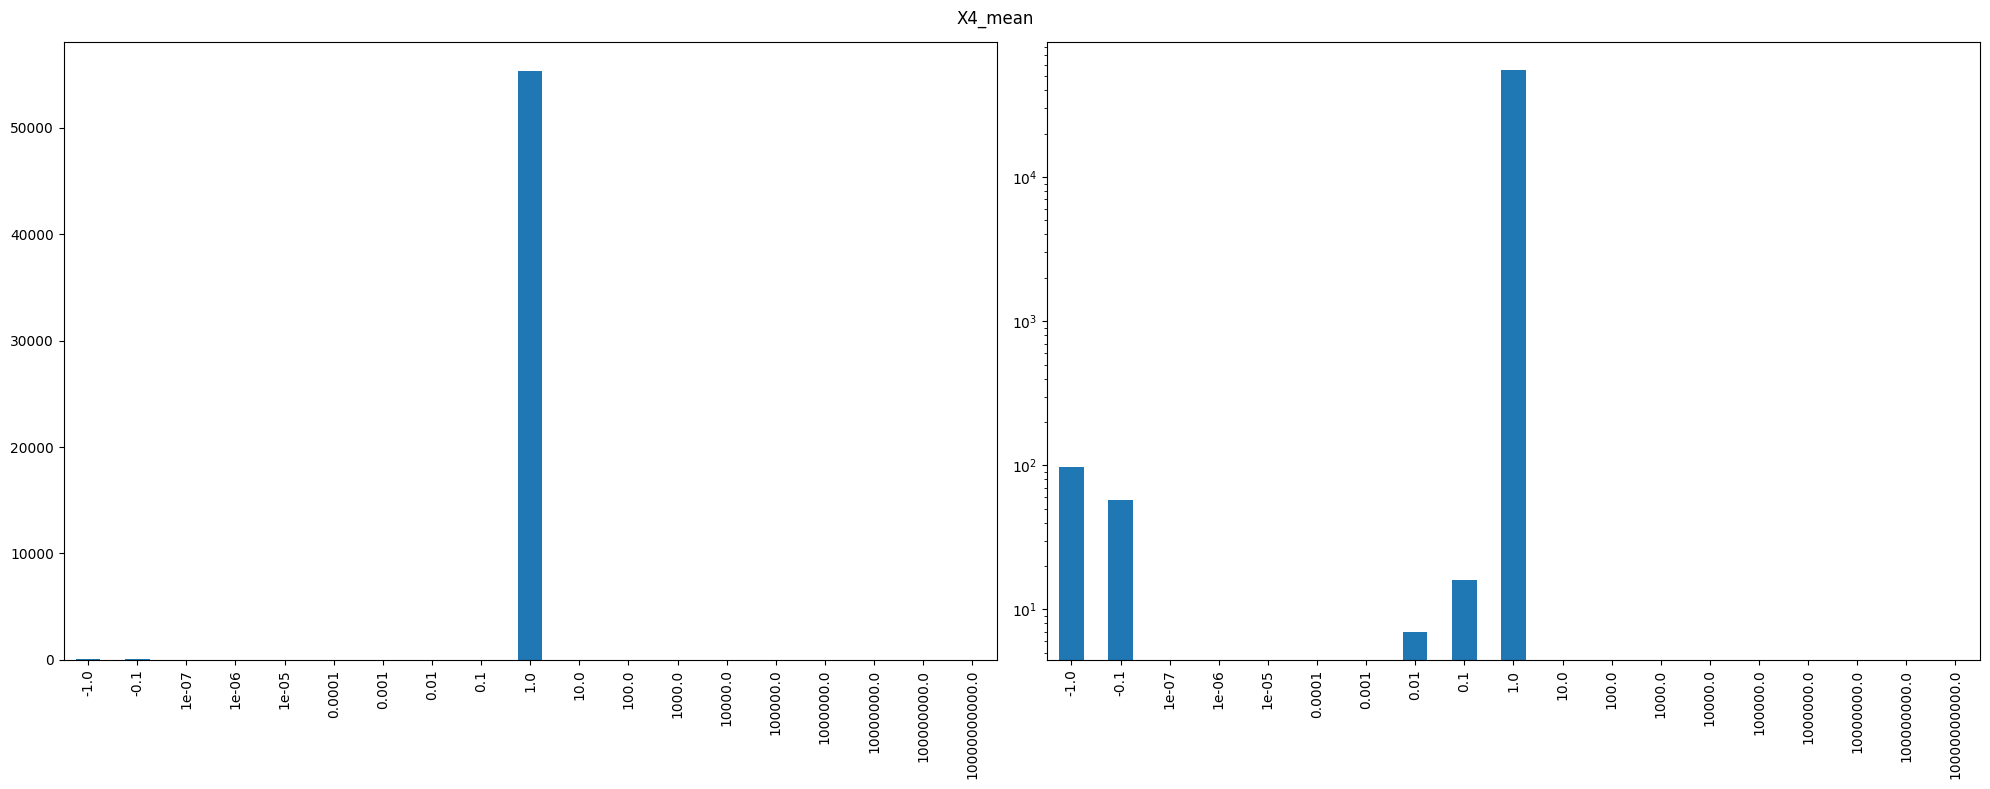

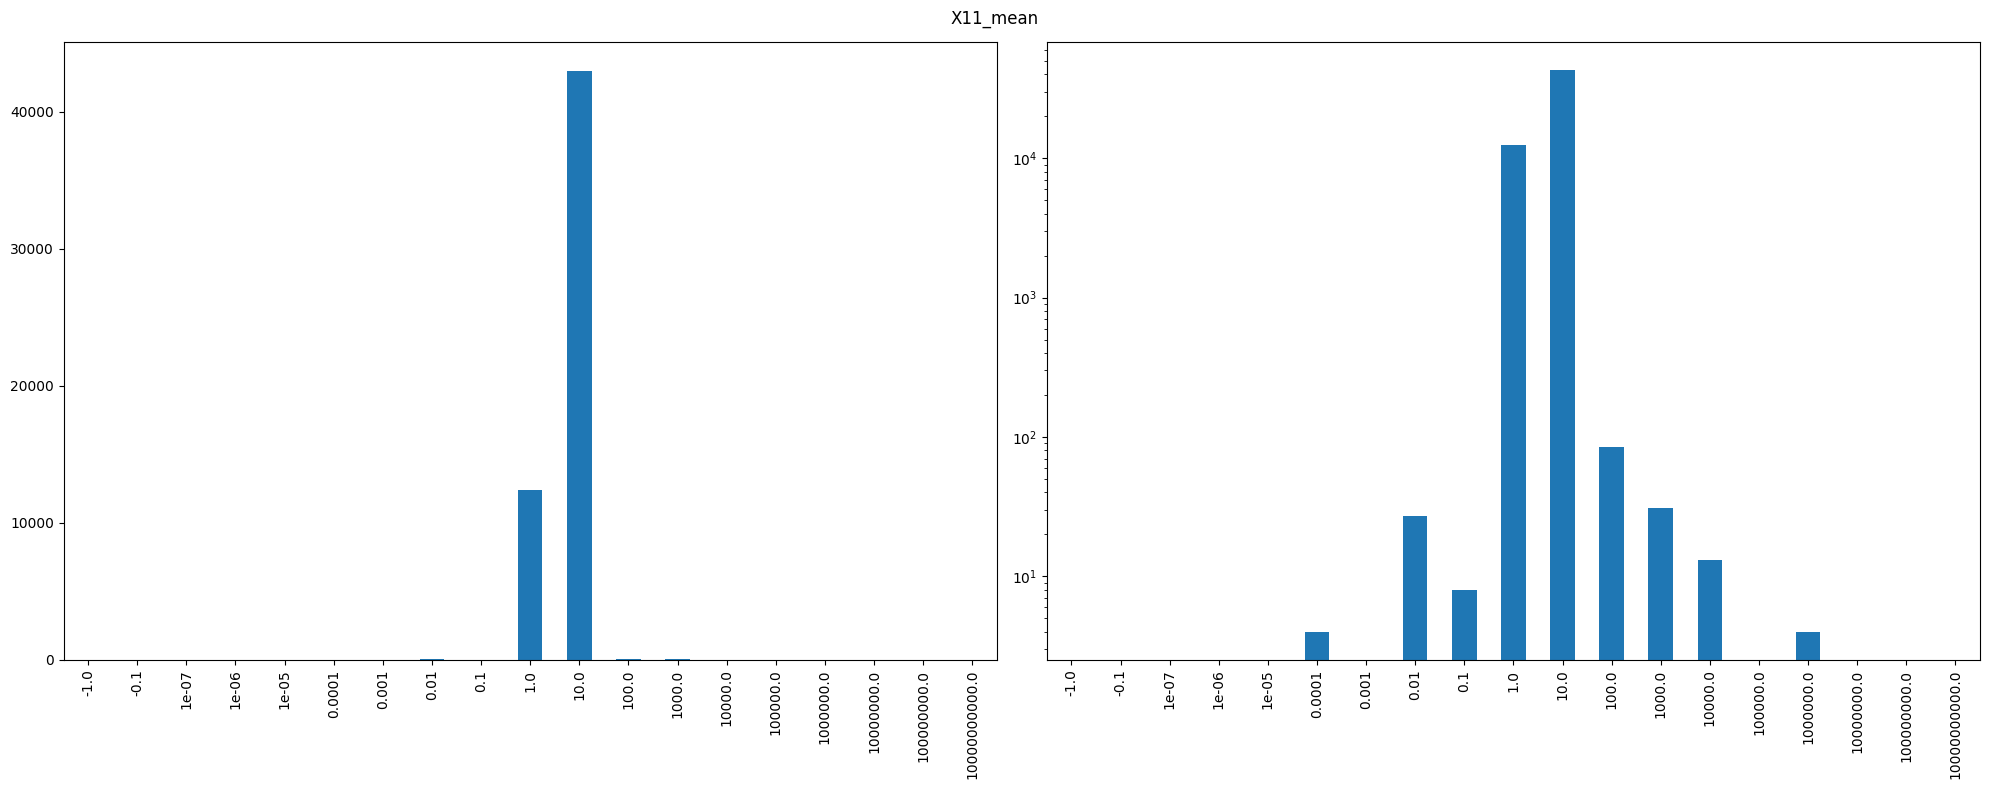

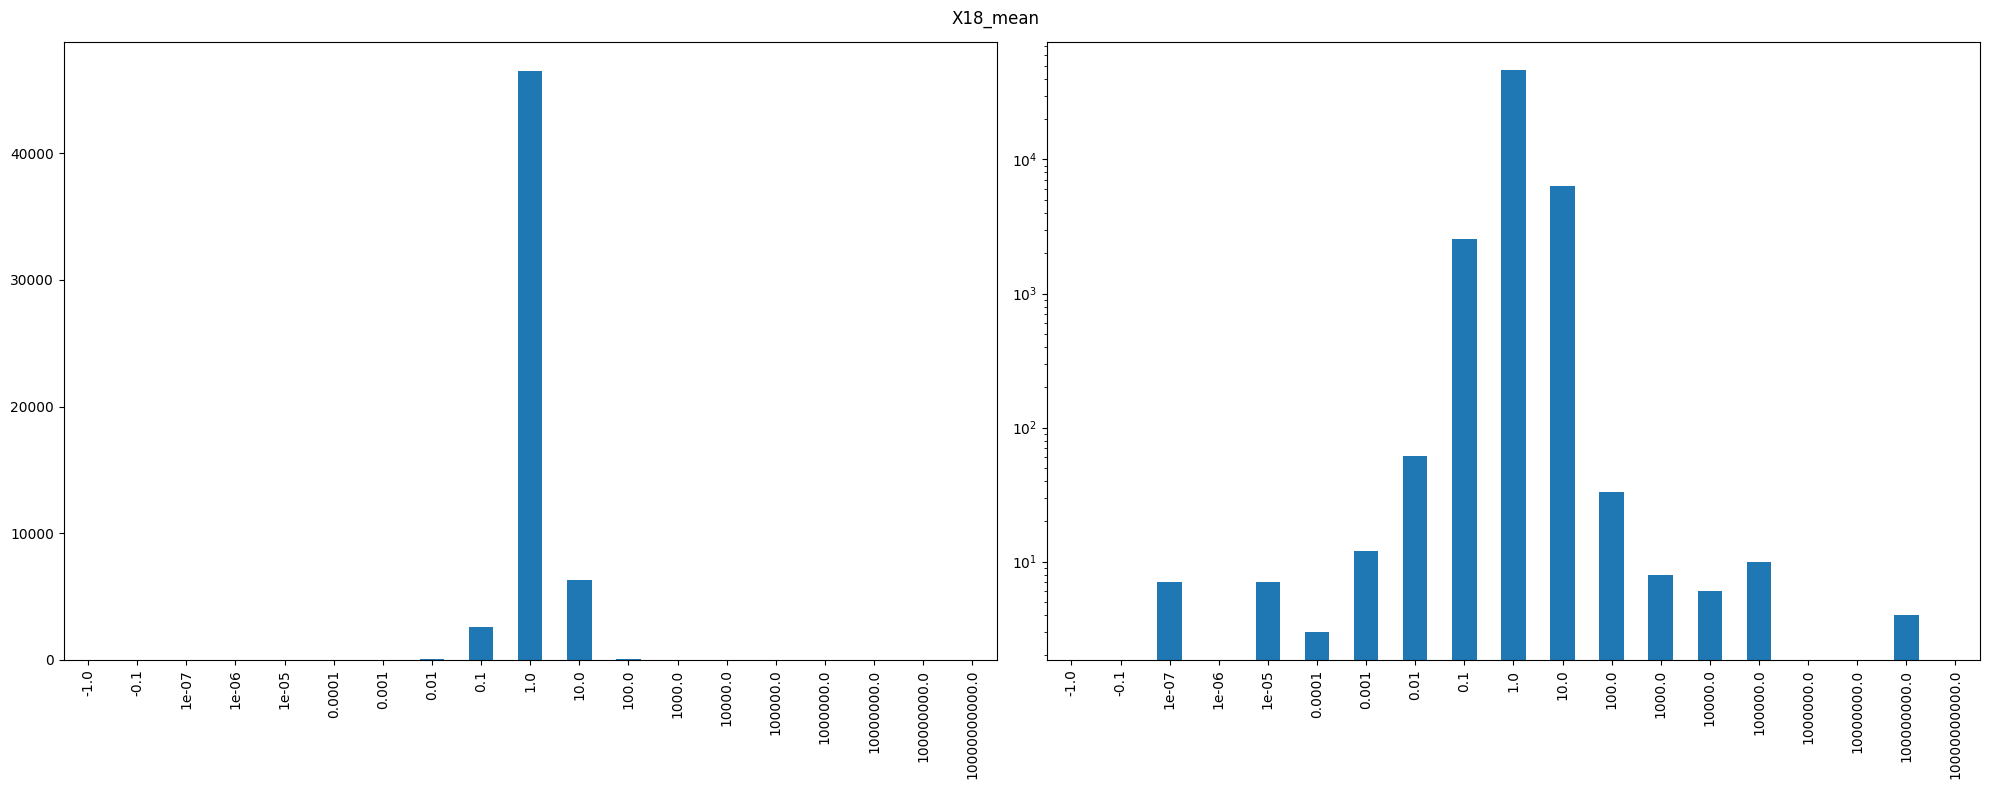

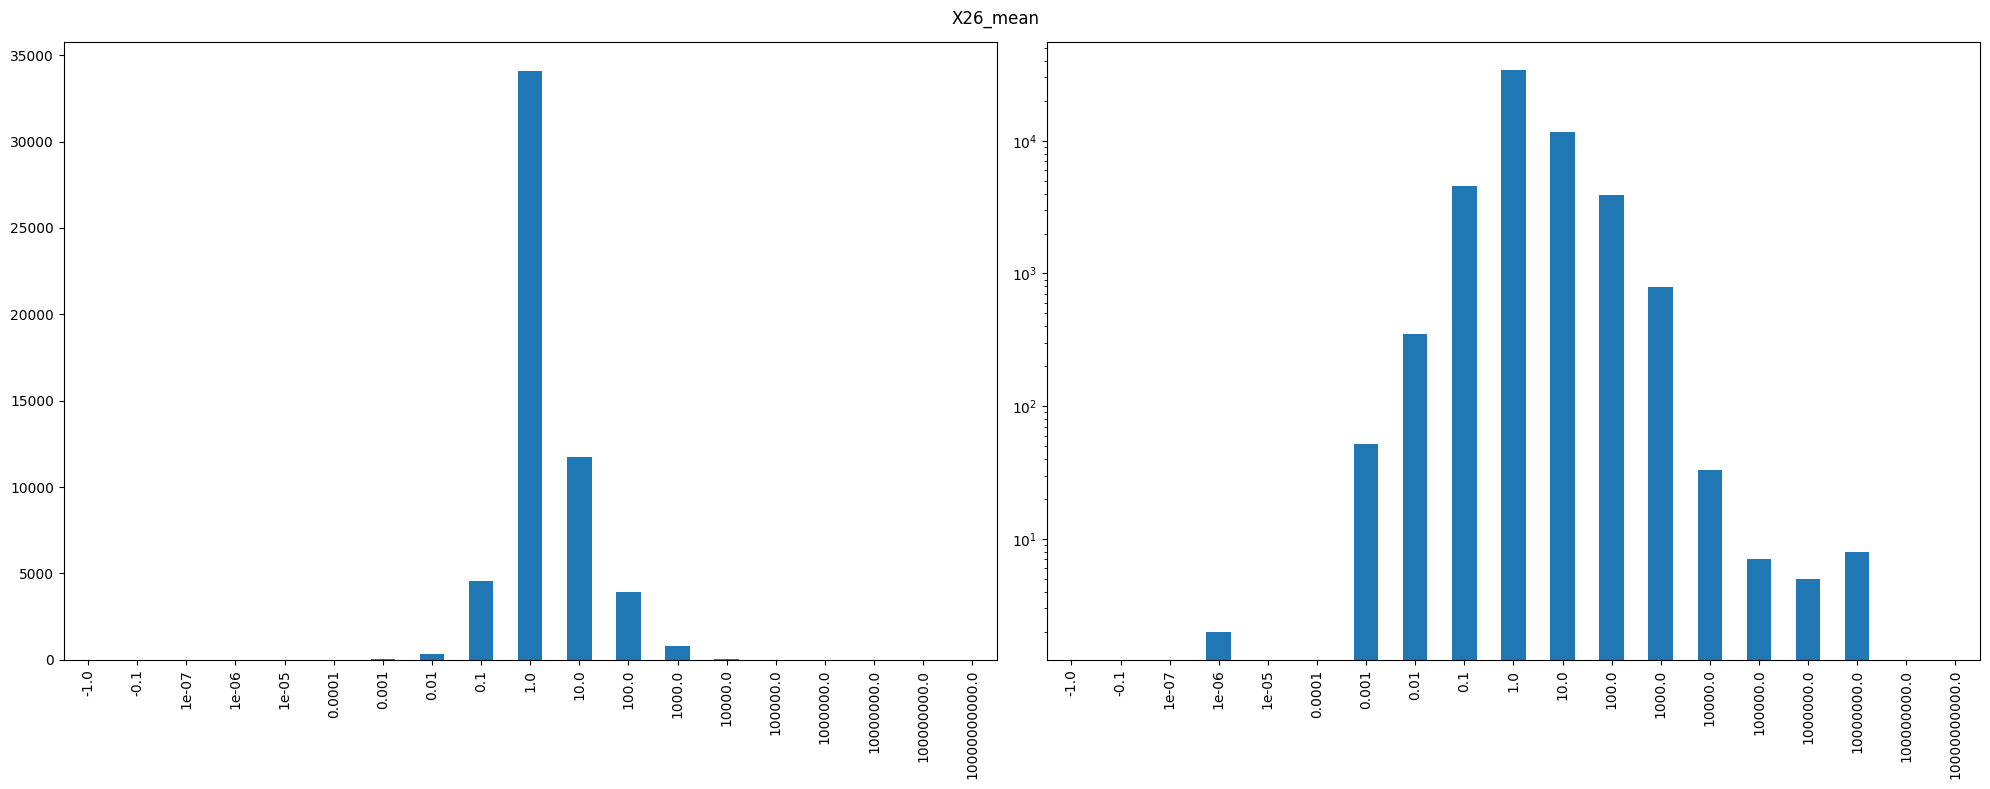

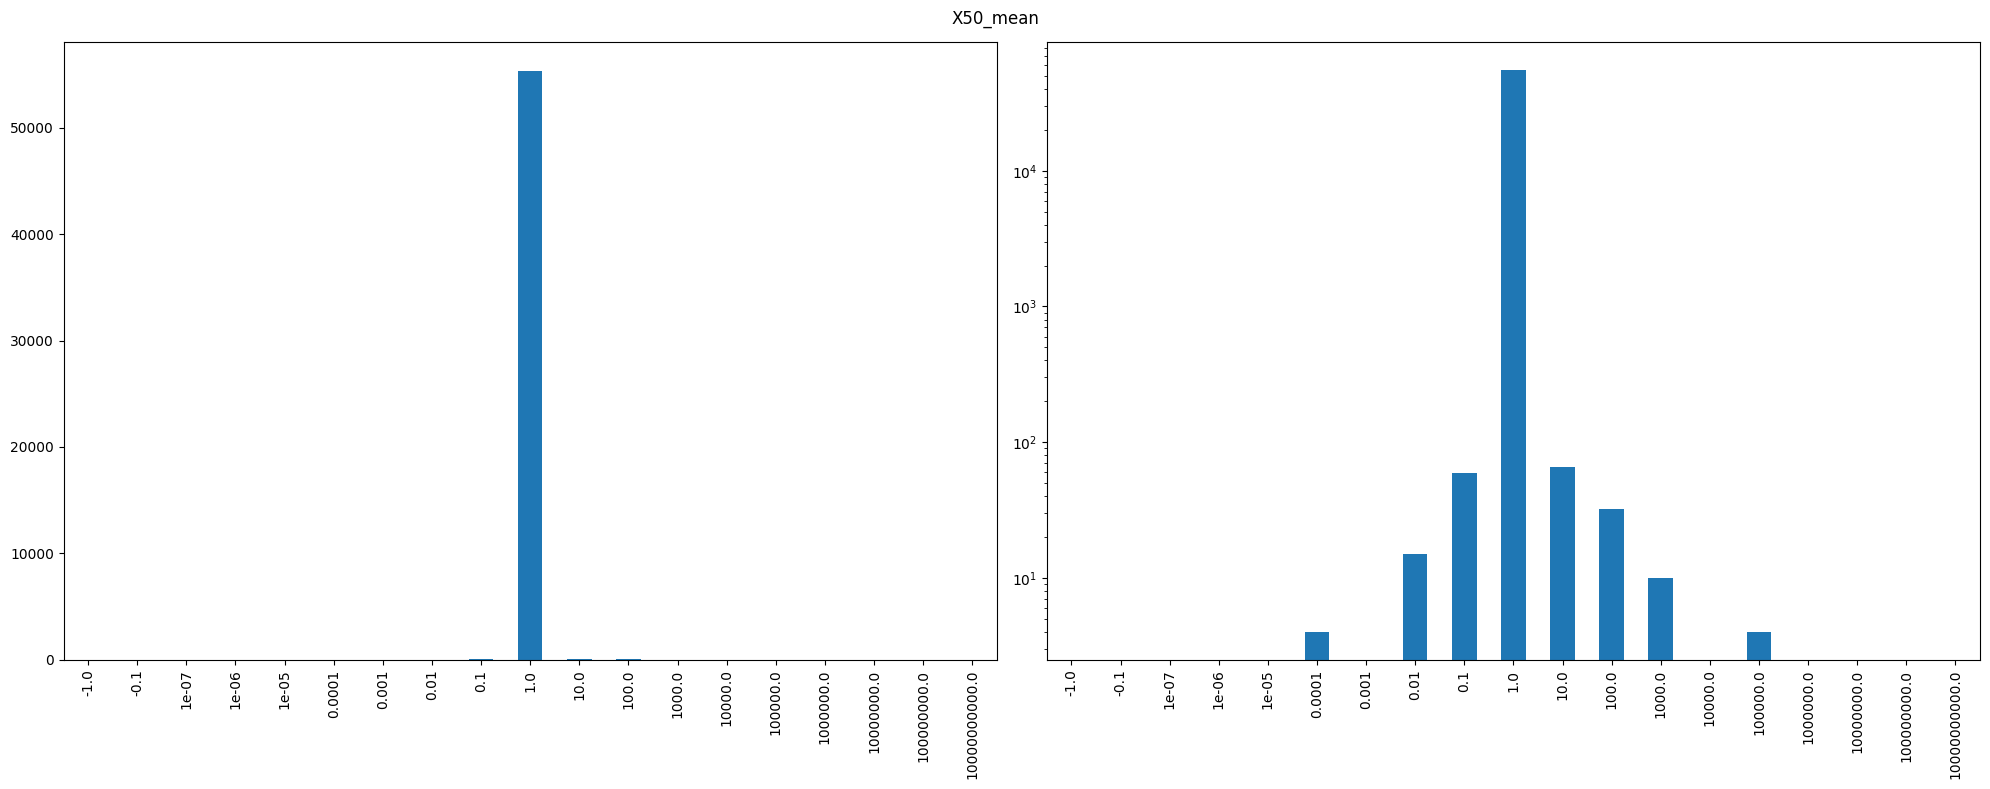

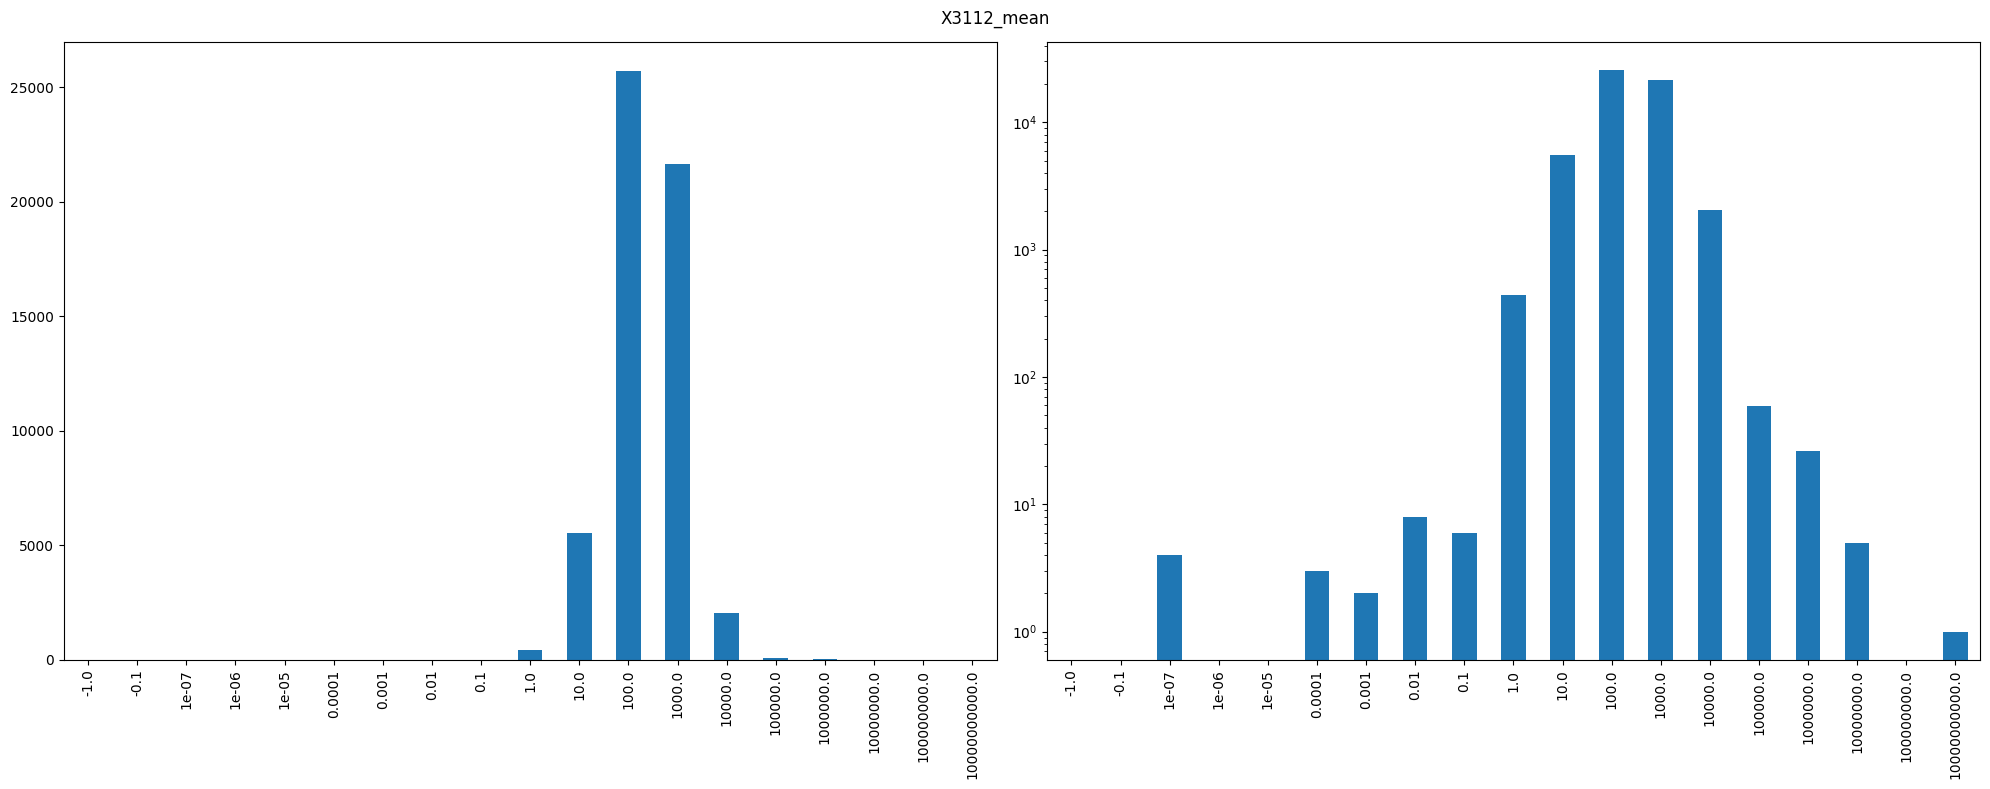

In [11]:
matplotlib.rcParams['figure.figsize'] = [20, 8]

for target in TARGETS:
    fig, ax = plt.subplots(1, 2)
    fig.suptitle(target)
    # ax.set_yscale('log')
    magnitude_counts[target].plot(kind='bar', ax=ax[0])
    magnitude_counts[target].plot(kind='bar', ax=ax[1])
    ax[1].set_yscale("log")
    plt.tight_layout()

In [12]:
magnitude_ranges = {"X4_mean": (1e-4, 1e1),
                    "X11_mean": (1e-1, 1e3),
                    "X18_mean": (1e-2, 1e2),
                    "X26_mean": (1e-2, 1e4),
                    "X50_mean": (1e-1, 1e2),
                    "X3112_mean": (1e0, 1e5)
                    }
magnitude_df = species_df[TARGETS].apply(lambda x: (x < magnitude_ranges[x.name][0]) | (x > magnitude_ranges[x.name][1]), axis=0)

magnitude_mask = magnitude_df.any(axis=1)

print(f"We have {magnitude_mask.sum()} magnitude outliers")


We have 246 magnitude outliers


In [13]:
outlier_counts = magnitude_df.sum(axis=1)
outlier_counts.name = 'outlier_counts'

In [14]:
species_df.drop(axis=1, labels=SD)[magnitude_mask].merge(magnitude_df, left_index=True, right_index=True).merge(outlier_counts, left_index=True, right_index=True).sort_values(by='counts')

,X4_mean_x,X11_mean_x,X18_mean_x,X26_mean_x,X50_mean_x,X3112_mean_x,counts,X4_mean_y,X11_mean_y,X18_mean_y,X26_mean_y,X50_mean_y,X3112_mean_y,outlier_counts
species,,,,,,,,,,,,,,
19748,0.572968,14.881009,0.071913,0.002595,1.274906,2.555565e+02,1,False,False,False,True,False,False,1
9087,0.777024,8.259927,28.522381,10545.523489,2.234383,2.444615e+03,1,False,False,False,True,False,False,1
12082,0.580881,17.205075,0.056962,0.002351,1.163554,2.311379e+02,1,False,False,False,True,False,False,1
10055,0.472231,24.085056,0.338485,0.001872,0.695602,5.741380e+02,1,False,False,False,True,False,False,1
16001,0.631853,8.562577,26.971318,957.997308,1.829443,3.002341e+05,1,False,False,False,False,False,True,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6018,0.525783,16.875318,0.101609,0.001573,0.990381,1.157968e+02,7,False,False,False,True,False,False,1
6824,-1.467042,0.003705,0.003066,155130.681300,1229.608076,1.132863e+00,7,True,True,True,True,True,False,5
4199,0.531698,10.464643,0.160042,0.002182,1.248040,7.908777e+01,7,False,False,False,True,False,False,1


In [15]:
species_df[TARGETS].to_csv('data/planttraits2024/orig_plant_means.csv')

Species ID: 6824
X4_mean: -1.467  X11_mean: 0.0037  X18_mean: 0.0031  X26_mean: 155130.6813  X50_mean: 1229.6081  X3112_mean: 1.1329  

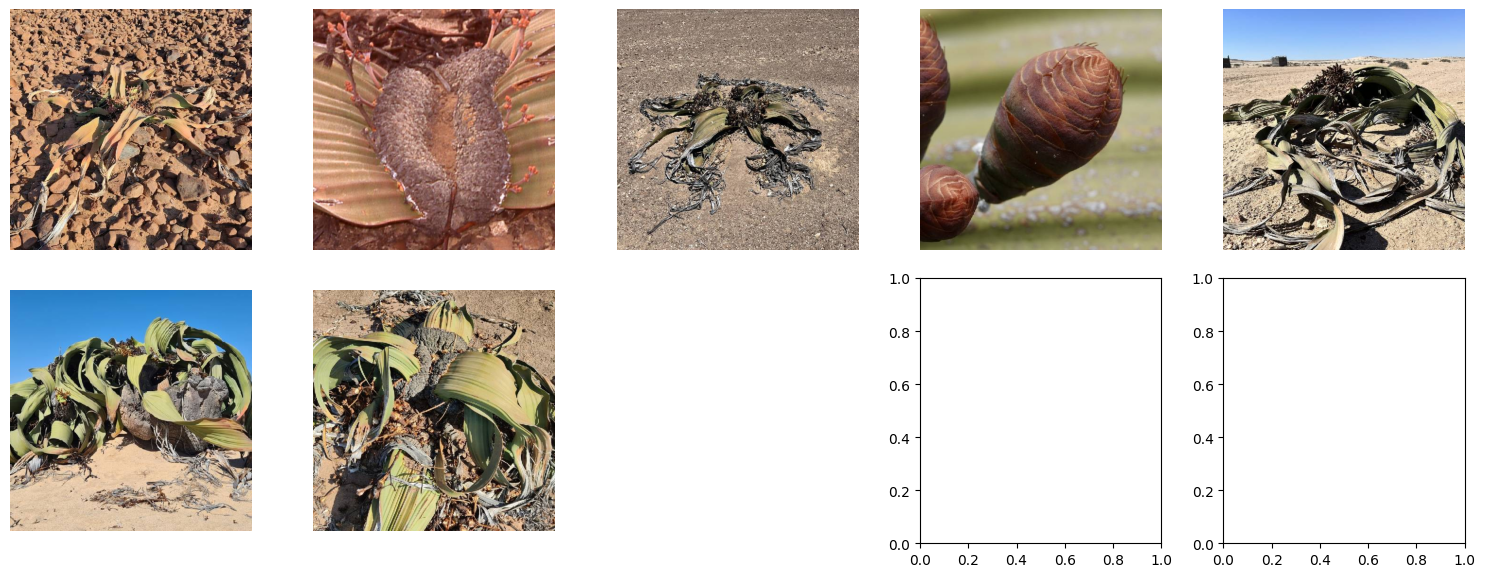

<Figure size 2000x800 with 0 Axes>

<Figure size 2000x800 with 0 Axes>

In [16]:
# display_plants(train_df, species_df[species_df.counts==1].sample(1).index[0])
display_plants(train_df, 6824)

In [17]:
z = 1.5
wo_outliers_train_df, outliers = drop_outliers(species_df, z, apply_cols=TARGETS)
all_outlier_species = outliers.index.union(magnitude_mask.index[magnitude_mask])
train_df_wo_outliers = train_df[~train_df.species.isin(all_outlier_species)]
print(train_df.shape[0])
print(train_df_wo_outliers.shape[0])


Dropping 1711 rows (285 outliers per column)
55489
50218


In [18]:

factors = pd.factorize(pd._libs.lib.fast_zip([train_df_wo_outliers[SPECIES].values for x in TARGETS]))[0]

ar =np.array((train_df_wo_outliers[SPECIES], factors)).T
mapped_species = {elem[0]: elem[1] for elem in np.unique(ar, axis=0)}
train_df_wo_outliers[SPECIES] = factors

wo_outliers_merged_transformed_train_df, merged_transformed_test_df, scalers = scale_variables(train_df_wo_outliers, test_df)

/tmp/ipykernel_66741/4115016643.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df_wo_outliers[SPECIES] = factors


In [19]:
outliers.merge(magnitude_df, left_index=True, right_index=True).sort_values(by='counts').drop(axis=1, labels=SD)

,X4_mean_x,X11_mean_x,X18_mean_x,X26_mean_x,X50_mean_x,X3112_mean_x,counts,X4_mean_y,X11_mean_y,X18_mean_y,X26_mean_y,X50_mean_y,X3112_mean_y
species,,,,,,,,,,,,,
19770,0.825682,4.954537,20.335997,20.058639,2.488116,2204.587965,1,False,False,False,False,False,False
16354,0.890387,11.974477,9.847920,64.848423,2.159845,4247.609577,1,False,False,False,False,False,False
16371,0.235503,20.598974,0.106230,0.486515,1.312122,7521.915682,1,False,False,False,False,False,False
16404,0.799650,5.298698,9.470863,0.570570,2.371543,1128.100459,1,False,False,False,False,False,False
8898,0.785842,7.721150,0.605885,0.714369,3.952149,1898.232999,1,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...
214,0.270183,30.287418,0.295646,1.191509,0.940755,668.577275,8,False,False,False,False,False,False
4003,0.902370,9.071988,5.678352,15.768247,3.595676,594.164584,8,False,False,False,False,False,False
1108,0.803078,4.768547,18.087927,6.694696,2.494715,1772.782106,8,False,False,False,False,False,False


Species ID: 5258
X4_mean: 0.4925  X11_mean: 5.9327  X18_mean: 12.5293  X26_mean: 9.0816  X50_mean: 1.9869  X3112_mean: 124.1104  

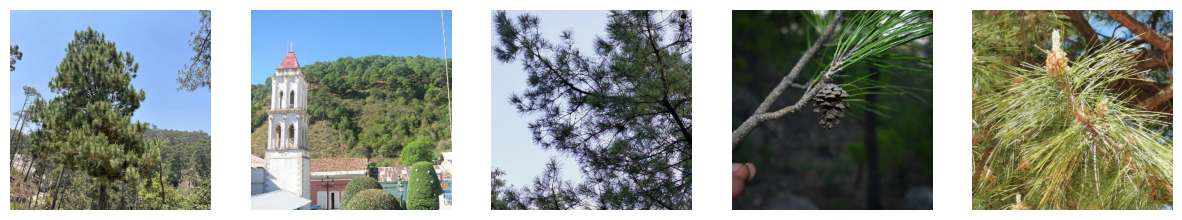

In [20]:
display_plants(train_df, 5258)

In [21]:
outliers

,X4_mean,X11_mean,X18_mean,X26_mean,X50_mean,X3112_mean,X4_sd,X11_sd,X18_sd,X26_sd,X50_sd,X3112_sd,counts
species,,,,,,,,,,,,,
2,0.796917,5.291251,8.552908,0.395241,2.343153,1130.096731,NaN,NaN,NaN,NaN,NaN,NaN,3
11,0.807147,5.119928,15.001974,3.078227,2.339621,1807.406736,0.006026,0.039627,0.569059,0.007285,0.014120,60.244475,5
14,0.877065,5.119935,8.675544,31.353342,1.148322,141.930292,0.016749,0.146652,0.161171,0.765056,0.027278,4.860720,4
15,0.806812,11.679107,7.768178,506.230705,1.590995,13585.084859,0.007378,0.479306,2.773774,70.359669,0.039160,6391.946596,2
27,0.805731,5.046315,3.618886,15.384261,1.515897,958.310735,0.001973,0.095510,0.166666,2.072971,0.032467,45.652095,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...
19701,0.828811,2.997447,0.565840,4.494797,2.737405,208.505308,0.005746,0.110920,0.078955,0.135815,0.062589,2.577666,1
19709,0.799614,19.473298,12.835516,12.511102,1.425442,8885.386419,NaN,NaN,NaN,NaN,NaN,NaN,1
19712,0.245678,53.264574,0.416785,0.801294,0.647206,1385.169312,NaN,NaN,NaN,NaN,NaN,NaN,1


In [22]:
from sklearn.preprocessing import StandardScaler

In [23]:
sc = StandardScaler()
scaled_species = sc.fit_transform(species_df[TARGETS].values)
scaled_species = pd.DataFrame(scaled_species, columns = TARGETS, index = species_df.index)

In [24]:
#Dropping removed species

scaled_species = scaled_species.loc[list(mapped_species)]
scaled_species.index = scaled_species.index.map(mapped_species)

In [25]:

ary = distance.cdist(scaled_species[TARGETS], scaled_species[TARGETS], metric='euclidean')
ary 
scaled_species[TARGETS][ary==ary.min()]

,X4_mean,X11_mean,X18_mean,X26_mean,X50_mean,X3112_mean
species,,,,,,
0,-0.728789,-0.008066,-0.007133,-0.011231,-0.007149,-0.007163
1,-0.264629,-0.007693,-0.007133,-0.011233,-0.007586,-0.007159
2,0.000601,-0.008270,-0.007133,-0.011235,-0.007761,-0.007156
3,-0.669323,-0.007807,-0.007133,-0.011192,-0.006800,-0.007148
4,0.038842,-0.007016,-0.007133,-0.011031,-0.007822,-0.007161
...,...,...,...,...,...,...
17939,-0.994032,-0.006785,-0.007133,-0.011231,-0.008013,-0.007161
17940,-0.864442,-0.008136,-0.007133,-0.011227,-0.007065,-0.007160
17941,-0.049442,-0.007799,-0.007133,-0.011185,-0.007317,-0.007141


In [26]:
ary = np.triu(ary)
ary[ary==0.] = np.inf

In [27]:
col_min = np.argmin(ary, axis=1)

In [28]:
ary[range(ary.shape[0]), col_min]

array([2.15968563e-04, 3.95431638e-04, 4.42140395e-04, ...,
       3.80571702e-01, 9.46361184e-01,            inf])

In [29]:
sorted_pairs = np.argsort(ary[range(ary.shape[0]), col_min])

In [30]:
i = 0
for i in range(5):
    idx = sorted_pairs[i], col_min[sorted_pairs[i]]
    print(idx, ary[idx])

(3546, 14476) 4.9109981815244355e-06
(9080, 9318) 1.6259806101483833e-05
(304, 6537) 1.8106411382371425e-05
(4128, 14372) 2.253732892209512e-05
(4222, 16227) 2.612282457916636e-05


Species ID: 6806
X4_mean: 0.4662  X11_mean: 18.8933  X18_mean: 0.1692  X26_mean: 0.054  X50_mean: 1.1202  X3112_mean: 707.7262  

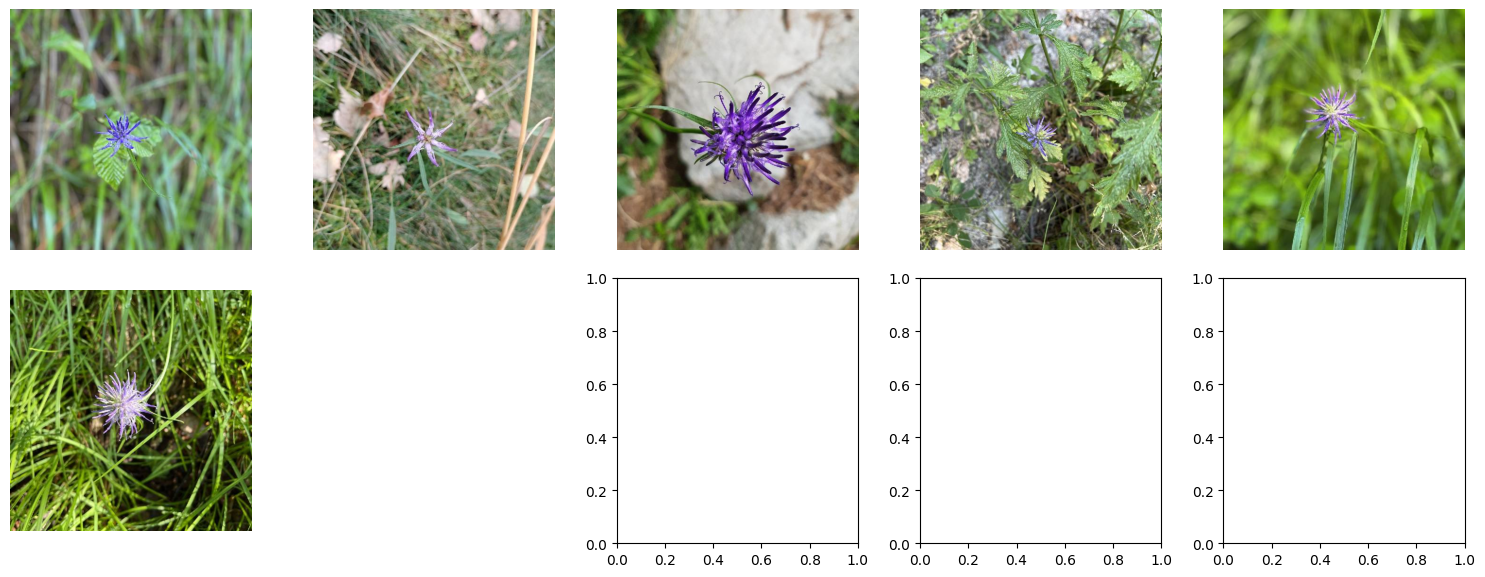

<Figure size 2000x800 with 0 Axes>

<Figure size 2000x800 with 0 Axes>

<Figure size 2000x800 with 0 Axes>



Species ID: 16941
X4_mean: 0.4662  X11_mean: 18.1762  X18_mean: 0.1543  X26_mean: 0.9588  X50_mean: 1.1624  X3112_mean: 136.9773  

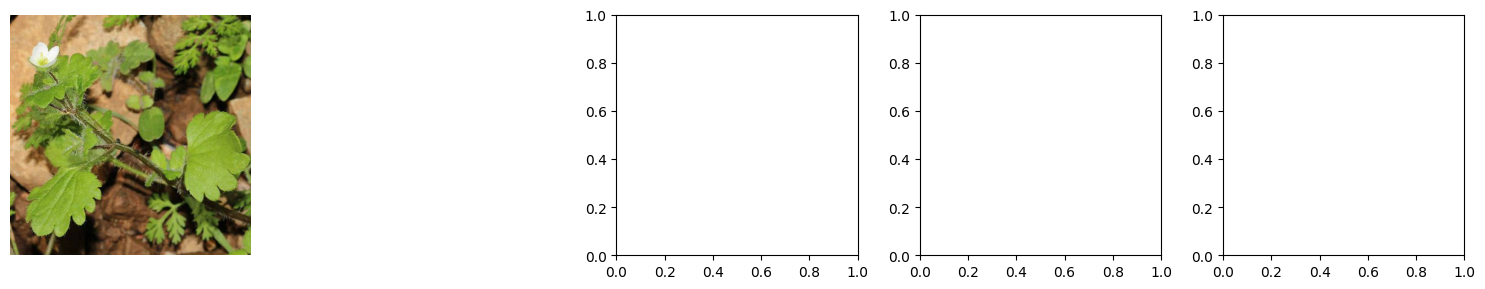

<Figure size 2000x800 with 0 Axes>

<Figure size 2000x800 with 0 Axes>

<Figure size 2000x800 with 0 Axes>

In [31]:
i = 118
display_plants(train_df_wo_outliers, sorted_pairs[i])
display_plants(train_df_wo_outliers, col_min[sorted_pairs[i]])

In [32]:
wo_outliers_species_df = species_df[species_df.index.isin(list(mapped_species))]
wo_outliers_species_df.index = wo_outliers_species_df.index.map(mapped_species)
wo_outliers_species_df['counts'] = wo_outliers_species_df.index.map(wo_outliers_merged_transformed_train_df[SPECIES].value_counts())

/tmp/ipykernel_66741/2190279431.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  wo_outliers_species_df['counts'] = wo_outliers_species_df.index.map(wo_outliers_merged_transformed_train_df[SPECIES].value_counts())


In [33]:
species_subset = wo_outliers_merged_transformed_train_df[SPECIES].value_counts()[wo_outliers_merged_transformed_train_df[SPECIES].value_counts()>7].sample(100).index
wo_outliers_species_df.loc[species_subset]

,X4_mean,X11_mean,X18_mean,X26_mean,X50_mean,X3112_mean,X4_sd,X11_sd,X18_sd,X26_sd,X50_sd,X3112_sd,counts
species,,,,,,,,,,,,,
6214,0.648015,64.844684,0.105235,0.025370,0.263519,353.141202,0.003133,1.614963,0.012479,0.001025,0.004139,91.136921,8
10629,0.549636,9.425751,7.671486,1.024958,0.951041,1995.756462,0.003333,0.772510,0.271271,0.031817,0.049796,72.831262,8
245,0.471569,11.462179,0.380739,2.976143,1.408328,702.251700,0.003333,0.217475,0.011743,0.102093,0.030315,28.792961,8
10114,0.542431,14.173624,1.188590,5.694927,1.500696,966.727968,0.000864,0.106637,0.029854,0.049765,0.002717,11.279874,8
1392,0.548927,22.254457,0.026446,0.889403,1.078627,26.807687,0.005525,2.461325,0.006872,0.084066,0.089705,4.208177,8
...,...,...,...,...,...,...,...,...,...,...,...,...,...
6316,0.669234,11.553869,5.815166,6.196005,1.052325,2859.533521,0.003713,0.115959,0.220881,0.251250,0.007615,260.822818,8
526,0.288467,13.485194,0.187577,0.127315,1.740628,71.773366,NaN,NaN,NaN,NaN,NaN,NaN,8
5755,0.629987,11.379916,0.522668,2.208334,2.310369,224.561578,0.006051,0.074793,0.009983,0.014875,0.018668,3.618305,8


In [34]:
SUBSET=False
if SUBSET:
    wo_outliers_merged_transformed_train_df = wo_outliers_merged_transformed_train_df[wo_outliers_merged_transformed_train_df[SPECIES].isin(species_subset)]
    mp = {wo_outliers_species_df.loc[species_subset].index[i]: i  for i in range(wo_outliers_species_df.loc[species_subset].shape[0])}

    wo_outliers_species_df =  wo_outliers_species_df.loc[species_subset]
    wo_outliers_species_df = wo_outliers_species_df.reset_index(drop=True)
    wo_outliers_species_df.index.name = SPECIES
    wo_outliers_merged_transformed_train_df[SPECIES] = wo_outliers_merged_transformed_train_df[SPECIES].map(mp)
    s = f'data/planttraits2024/transformed_train_df_species_{z}z_targets_subset.csv'
    test_s = f'data/planttraits2024/transformed_test_df_species_{z}z_targets_subset.csv'
    sp_s = "data/planttraits2024/wo_outliers_plant_means_subset.csv"
else:
    s = f'data/planttraits2024/transformed_train_df_species_{z}z_targets.csv'
    test_s = f'data/planttraits2024/transformed_test_df_species_{z}z_targets.csv'
    sp_s = "data/planttraits2024/wo_outliers_plant_means.csv"

wo_outliers_species_df.to_csv(sp_s, index=True)
wo_outliers_merged_transformed_train_df.to_csv(s, index=False)
merged_transformed_test_df.to_csv(test_s, index=False)

print(s)

from joblib import dump, load
dump(scalers[1], f'data/std_scaler_species_{z}z.bin', compress=True)

data/planttraits2024/transformed_train_df_species_1.5z_targets_subset.csv


['data/std_scaler_species_1.5z.bin']